### Run lisflood with water extraction to the groundwater

In this notebook we'll test the following:
- run lisflood for one time step
- then add a meter of water depth everywhere
- run it for several days to get water flowing through the mesh
- then extract water per time step to mimic a certain infiltration rate

In [1]:
%matplotlib inline
from bmi.wrapper import BMIWrapper
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

### start your engines

In [2]:
wrapper = BMIWrapper(engine="/home/hcwinsemius/lisflood/liblisflood.so", configfile='/home/hcwinsemius/git/barotse/lisflood/Barotse_debug.par')
wrapper.initialize()
hs = []
# get the water level
h_orig = wrapper.get_var("H").copy()

h = wrapper.get_var("H")


# h[:] += 1.


# dem = wrapper.get_var("DEM").copy()
# print(f"Amount of water is {h.mean()}")
# # add a bunch of water
# # h[250, 5] += 10.
# # wrapper.get_var('H')[:] = h_new
# # wrapper.update()
# # h1 = wrapper.get_var("H").copy()
# print(wrapper.get_current_time())
# # h[250, 5] += 10.
# # h[250, 5] += 10.
# # h[:] +=10

# for n in range(50):
#     hs.append(wrapper.get_var("H").copy())
#     for i in range(100):
#         wrapper.update()
# print(wrapper.get_current_time())
# print(f"Amount of water is {hs[-1][:].mean()}")

# plt.figure(figsize=(10, 18))
# h1 = wrapper.get_var("H").copy()
# wrapper.update()
# wrapper.update()
# wrapper.update()
# wrapper.update()
# wrapper.update()
# h2 = wrapper.get_var("H").copy()
# plt.imshow(h)
# plt.colorbar()



In [3]:
t = 0 # is the moment in time that we want to plot something. After each plot we increase this by 86400 seconds (one day)
t1 = 0
p = 0  # plot number (let's do 100 plots for now)
volume = []
h_timeseries = [wrapper.get_var("H").copy()]  # start empty list where we store daily water depths
plt.figure(figsize=(20, 10))
loss = 0
loss_estimate = 0
for p in tqdm(range(15)):
    while wrapper.get_current_time() < t:
        # read current time
        t2 = wrapper.get_current_time()
        timestep = t2 - t1
        t1 = t2
        wrapper.update()
        h = wrapper.get_var("H")[:].copy()
#         reduce = -np.minimum(h, 10./1000)
#         wrapper.get_var("H")[:] += reduce

#     if wrapper.get_current_time()> t:
        # we passed t, so let's plot something
#         print('Time step {:d} size is {:f} seconds'.format(p, timestep))
#         p += 1 # we increase the plot number by one
#         plt.imshow(wrapper.get_var('H'), vmin=0., vmax=.8)
    h_timeseries.append(wrapper.get_var('H')[:].copy())
#     print(f"Amount of water is {h_timeseries[-1].mean()}")
    if t > 0:
        loss += (h_timeseries[-1] - h_timeseries[-2]).sum()*500*500
        # estimate loss from wetted areas
        h = wrapper.get_var("H")[:].copy()
        loss_estimate += 0.000004*86400*np.float32(h > 0.).sum()*500*500
    
    print(f"Time: {t}, Vol: {h_timeseries[-1].sum()*500*500} Water loss is {loss/1e6}, estimated {loss_estimate/1e6}")
    
    t += 86400 # we add 3 hours 
# 100 days have passed. We're done, so we close the model
h = wrapper.get_var("H").copy()
wrapper.finalize()


  0%|          | 0/15 [00:00<?, ?it/s]

Time: 0, Vol: 10353989250.0 Water loss is 0.0, estimated 0.0
Time: 86400, Vol: 10317772688.142605 Water loss is -36.21656185739541, estimated 4626.2016
Time: 172800, Vol: 10291954683.13005 Water loss is -62.03456686994819, estimated 9265.6224
Time: 259200, Vol: 10246753728.527792 Water loss is -107.23552147220819, estimated 13910.4864
Time: 345600, Vol: 10184180373.502842 Water loss is -169.80887649716058, estimated 18559.4976
Time: 432000, Vol: 10142771856.409271 Water loss is -211.21739359072745, estimated 23214.816
Time: 518400, Vol: 10083354301.080202 Water loss is -270.6349489197997, estimated 27875.4912
Time: 604800, Vol: 10025707535.324978 Water loss is -328.28171467502114, estimated 32539.0176
Time: 691200, Vol: 9981225005.079302 Water loss is -372.7642449207009, estimated 37204.0128
Time: 777600, Vol: 9945212142.983273 Water loss is -408.77710701672447, estimated 41870.4768
Time: 864000, Vol: 9912440575.859365 Water loss is -441.54867414063466, estimated 46538.2368
Time: 95040

<Figure size 1440x720 with 0 Axes>

In [15]:
np.float32(h > 0.05).sum()*500*500*0.000004*86400/1e6


2828.3904

In [12]:
0.1/864

0.00011574074074074075

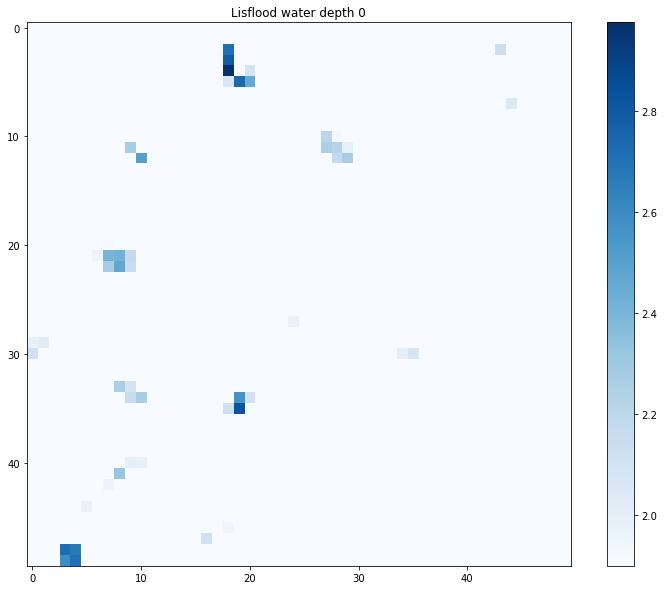

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
def update_plot(i):
    fld = h_timeseries[i]
    ax.set_title(f'Lisflood water depth {i}')
    p.set_array(fld[250:300, 150:200])

fig = plt.figure(figsize=(13, 10))
ax = plt.subplot(111)
p = plt.imshow(h_timeseries[0][250:300,150:200], vmin=1.9, cmap="Blues")

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, len(h_timeseries)),
    interval=250,     # ms between frames
)
plt.colorbar()


HTML(ani.to_html5_video())
# ani.save('lisflood_3m_water.mp4', fps=4, dpi=200)

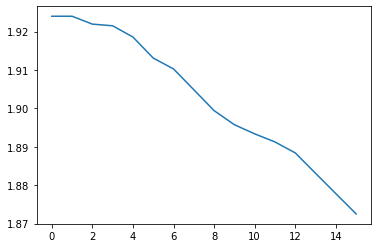

In [5]:
ts = np.array([h_[260, 178] for h_ in h_timeseries])
plt.plot(ts)
# plt.plot(h_timeseries[50][-1][150:200])

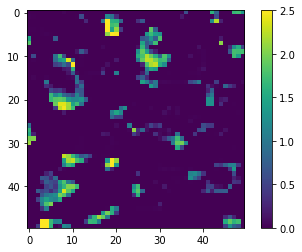

In [11]:
plt.imshow(h_timeseries[0][250:300,150:200], vmax=2.5);plt.colorbar()

### start your engines with infiltration
Now exactly the same but assuming infiltration of maximum 100 mm per 3-hourly step

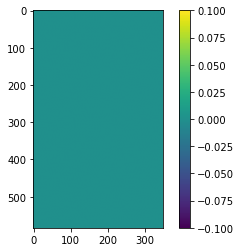

In [35]:
wrapper = BMIWrapper(engine="/home/hcwinsemius/lisflood/liblisflood.so", configfile='/home/hcwinsemius/git/barotse/lisflood/Barotse_noevap_glofrim.par')
# wrapper = BMIWrapper(engine="/home/hcwinsemius/lisflood/liblisflood.so", configfile='/home/hcwinsemius/git/barotse/example_models/LFP_synthetic_2D/LFP_syntheticTestCase_2D_zeros.par')

wrapper.initialize()
# do one time step
wrapper.update()
# add a bunch of water in the middle (y-coord 250 is the middle)
h = wrapper.get_var('H').copy()
# add a bunch of water
plt.imshow(h)
plt.colorbar()
h += 1.
wrapper.get_var('H')[:] = h

In [36]:
t = 0 # is the moment in time that we want to plot something. After each plot we increase this by 86400 seconds (one day)
t1 = 0
p = 0  # plot number (let's do 100 plots for now)
volume = []
h_timeseries = []  # start empty list where we store daily water depths
r_timeseries = []
plt.figure(figsize=(20, 10))
while p < 50:
    # read current time
    t2 = wrapper.get_current_time()
    timestep = t2 - t1
    t1 = t2
    wrapper.update()
    if wrapper.get_current_time()> t:
        del h
        # we passed t, so let's plot something
        print('Time step {:d} size is {:f} seconds'.format(p, timestep))
        p += 1 # we increase the plot number by one
        t += 3600*3 # we add 3 hours 
        h = wrapper.get_var('H').copy()
        reduce = -np.minimum(h, 1000./1000)
        h += reduce
        print(reduce.mean())
#         h_new = np.maximum(h - 100./1000, 0.)  # reduce by 100, prevent under zero
        wrapper.get_var('H')[:] = h
        h_timeseries.append(h.copy())
        r_timeseries.append(-reduce)
        
# 100 days have passed. We're done, so we close the model
wrapper.finalize()

Time step 0 size is 60.000000 seconds
-0.27674811473050187
Time step 1 size is 23.457695 seconds
-0.09275294418815415
Time step 2 size is 23.250392 seconds
-0.07810689467812734
Time step 3 size is 23.164842 seconds
-0.07558682981416784
Time step 4 size is 23.146461 seconds
-0.07484218067717785
Time step 5 size is 23.153332 seconds
-0.07431575158153085
Time step 6 size is 23.137320 seconds
-0.07389107197434992
Time step 7 size is 23.147723 seconds
-0.07370619858848854
Time step 8 size is 23.135153 seconds
-0.07334463816472851
Time step 9 size is 23.126457 seconds
-0.07310588295647835
Time step 10 size is 23.135005 seconds
-0.07272599119971196
Time step 11 size is 23.128512 seconds
-0.07247266229773197
Time step 12 size is 23.124967 seconds
-0.07226880002913244
Time step 13 size is 23.122772 seconds
-0.07205915371784072
Time step 14 size is 23.121850 seconds
-0.07179499677619539
Time step 15 size is 23.122636 seconds
-0.07173566142402517
Time step 16 size is 23.124388 seconds
-0.07173082

<Figure size 1440x720 with 0 Axes>

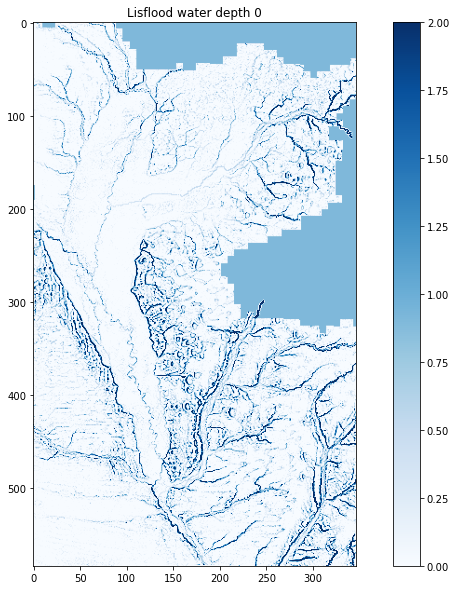

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
def update_plot(i):
    fld = h_timeseries[i]
    ax.set_title(f'Lisflood water depth {i}')
    p.set_array(fld)

fig = plt.figure(figsize=(13, 10))
ax = plt.subplot(111)
p = plt.imshow(h_timeseries[0], vmin=0., vmax=2., cmap="Blues")

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, len(h_timeseries)),
    interval=250,     # ms between frames
)
plt.colorbar()
# from IPython.display import HTML
HTML(ani.to_html5_video())
# ani.save('lisflood_3m_water_infiltration.mp4', fps=4, dpi=200)

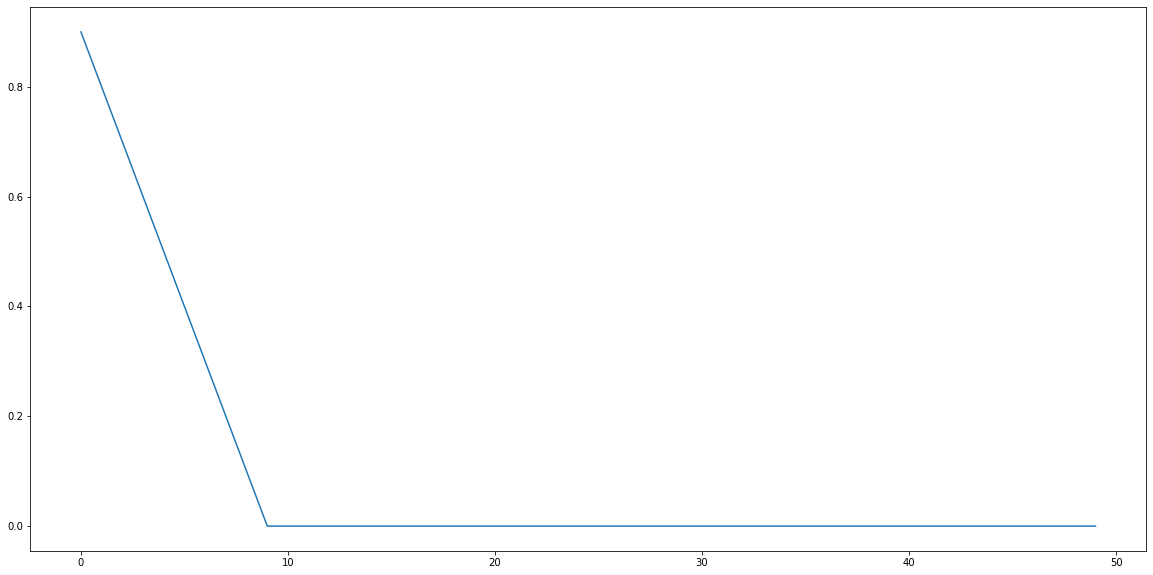

In [33]:
f= plt.figure(figsize=(20, 10))
plt.plot(np.array([h[250, 5] for h in h_timeseries]))

# plt.plot(h_timeseries[50][-1][150:200])

NameError: name 'r_timeseries' is not defined

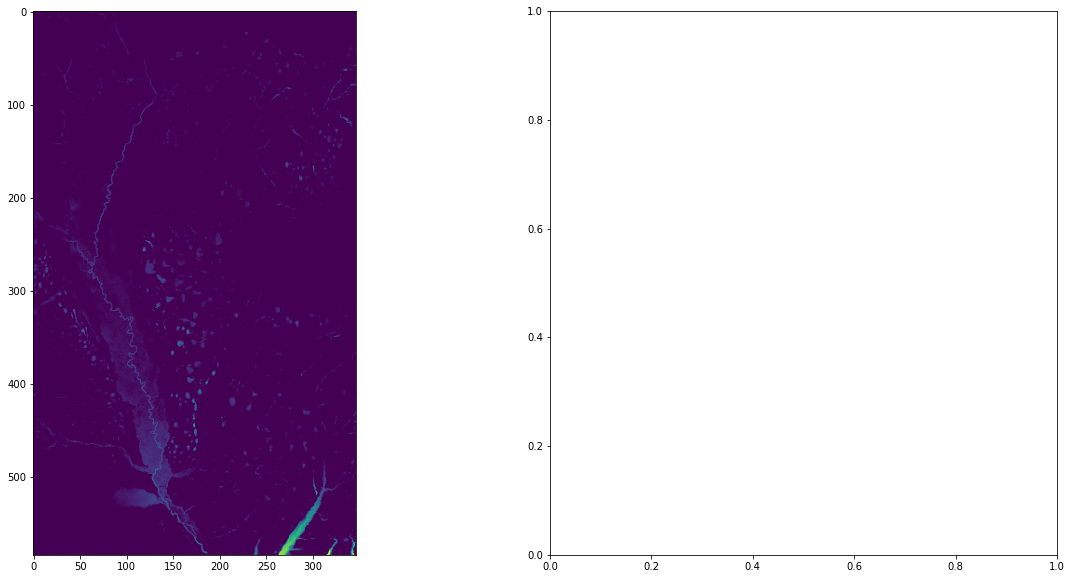

In [12]:
f = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(h_timeseries[50])


plt.subplot(122)
plt.imshow(r_timeseries[50])


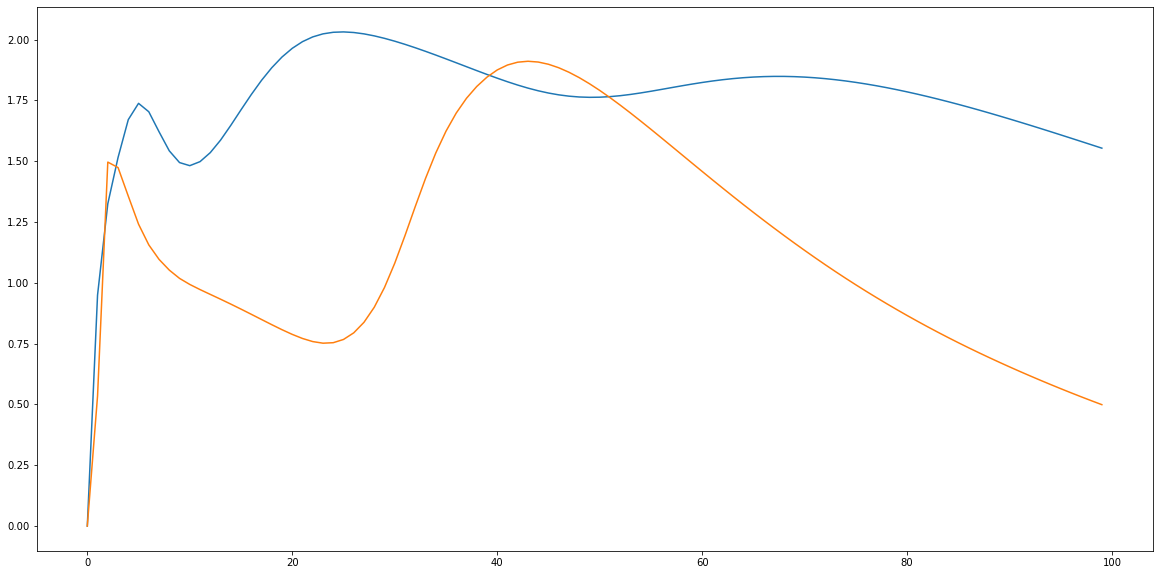

In [5]:
f= plt.figure(figsize=(20, 10))
plt.plot(np.array([h[-1, 188] for h in h_timeseries]))
plt.plot(np.array([h[350, 110] for h in h_timeseries]))

In [9]:
f= plt.figure(figsize=(20, 10))
plt.plot(np.array([h[-1, 188] for h in h_timeseries]))
plt.plot(np.array([h[350, 110] for h in h_timeseries]))

60